# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [6]:
% matplotlib inline
import numpy as np
import urllib2, requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd

In [7]:
   # create a new data frame
pd.set_option('max_colwidth',500)    # to remove column limit (default is 50. Otherwise, we'll lose some info)

In [63]:
#YOUR_CITY = 'Hong+Kong'
#url_template = "http://www.indeed.com/jobs?q=data+scientist&l={}&start={}"

# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

#results = []

def job_info_df(url_input, city_list):
    
    df_temp = pd.DataFrame()
    max_results_per_city = 5000 # Set this to a high-value (5000) to generate more results. 

    for city in city_list:
        
        for start in range(0, max_results_per_city, 10):
            
            url_work = url_input.format(city, start)
     
            contents = BeautifulSoup(urllib2.urlopen(url_work), "lxml") 
            contentsElements = contents.find_all('div', attrs={'class' : '  row  result'}) 
            contentsElements.extend(contents.find_all('div', attrs={'class' : 'lastRow  row  result'}))
                 
            for elem in contentsElements: 
                try:
                    company = elem.find('span', attrs={'itemprop':'name'}).getText().strip() #strips off whitespace 
                except AttributeError:
                    company = '-'

                try:
                    salary = elem.find('nobr').getText().strip()
                except AttributeError:   
                    salary = '-'

                job_title = elem.find('a', attrs={'class':'turnstileLink'}).attrs['title']
                home_url = "http://www.indeed.com"
                job_link = "%s%s" % (home_url,elem.find('a').get('href'))

                job_addr = elem.find('span', attrs={'itemprop':'addressLocality'}).getText()

                job_posted = elem.find('span', attrs={'class': 'date'}).getText()

                # add a record of job info to our data frame
                df_temp = df_temp.append({'company': company, 
                                'salary': salary,
                                'job_title': job_title, 
                                'job_link': job_link, 
                                'job_posted': job_posted,
                                'job_location': job_addr,
                                'job_city': city
                               }, ignore_index=True)
        
    return df_temp



In [64]:
hk_city_list = ['Hong+Kong']
df_hk = job_info_df("http://www.indeed.hk/jobs?q=data+scientist&l={}&start={}", hk_city_list)

In [65]:
us_city_list = ['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', 'Boston', 'Cambridge', 'San+Diego', 'Washington', 
                 'Palo+Alto','St.+Louis']

df = job_info_df("http://www.indeed.com/jobs?q=data+scientist&l={}&start={}", us_city_list)


In [70]:
df_us = df.copy()

In [71]:
df = pd.concat([df_us,df_hk],ignore_index=True)

In [72]:
df_original = df.copy()

In [75]:
df_hk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4008 entries, 0 to 4007
Data columns (total 7 columns):
company         4008 non-null object
job_city        4008 non-null object
job_link        4008 non-null object
job_location    4008 non-null object
job_posted      4008 non-null object
job_title       4008 non-null object
salary          4008 non-null object
dtypes: object(7)
memory usage: 219.3+ KB


All HK jobs have no salary. 

In [73]:
len(df['job_link'].unique())

8725

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69715 entries, 0 to 69714
Data columns (total 7 columns):
company         69715 non-null object
job_city        69715 non-null object
job_link        69715 non-null object
job_location    69715 non-null object
job_posted      69715 non-null object
job_title       69715 non-null object
salary          69715 non-null object
dtypes: object(7)
memory usage: 3.7+ MB


In [76]:
df.head()

,company,job_city,job_link,job_location,job_posted,job_title,salary
0,SoundCloud,New+York,http://www.indeed.com/rc/clk?jk=c1f44bb3c93cdb5d&fccid=af61bf95b89c7cb2,"New York, NY 10003 (Greenwich Village area)",1 day ago,"Data Scientist, Analytics",-
1,SoundCloud,New+York,http://www.indeed.com/rc/clk?jk=313c390c5b077989&fccid=af61bf95b89c7cb2,"New York, NY 10003 (Greenwich Village area)",4 days ago,Data Engineer,-
2,Capital One,New+York,http://www.indeed.com/rc/clk?jk=d129f9bb04293359&fccid=b85c5070c3d3d8c8,"New York, NY",5 days ago,Data Scientist,-
3,Time Inc,New+York,http://www.indeed.com/rc/clk?jk=ff6d2e12514bb2fc&fccid=05dd220636741a04,"New York, NY 10020 (Midtown area)",4 days ago,Data Scientist,-
4,"Cognical, Inc.",New+York,http://www.indeed.com/rc/clk?jk=2676697f29497db2&fccid=309f5dd3a87072dc,"New York, NY 10001 (Chelsea area)",5 days ago,Data Scientist,-


In [77]:
df= df.drop_duplicates('job_link')

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8725 entries, 0 to 70153
Data columns (total 7 columns):
company         8725 non-null object
job_city        8725 non-null object
job_link        8725 non-null object
job_location    8725 non-null object
job_posted      8725 non-null object
job_title       8725 non-null object
salary          8725 non-null object
dtypes: object(7)
memory usage: 545.3+ KB


In [80]:
df.head()

,company,job_city,job_link,job_location,job_posted,job_title,salary
0,SoundCloud,New+York,http://www.indeed.com/rc/clk?jk=c1f44bb3c93cdb5d&fccid=af61bf95b89c7cb2,"New York, NY 10003 (Greenwich Village area)",1 day ago,"Data Scientist, Analytics",-
1,SoundCloud,New+York,http://www.indeed.com/rc/clk?jk=313c390c5b077989&fccid=af61bf95b89c7cb2,"New York, NY 10003 (Greenwich Village area)",4 days ago,Data Engineer,-
2,Capital One,New+York,http://www.indeed.com/rc/clk?jk=d129f9bb04293359&fccid=b85c5070c3d3d8c8,"New York, NY",5 days ago,Data Scientist,-
3,Time Inc,New+York,http://www.indeed.com/rc/clk?jk=ff6d2e12514bb2fc&fccid=05dd220636741a04,"New York, NY 10020 (Midtown area)",4 days ago,Data Scientist,-
4,"Cognical, Inc.",New+York,http://www.indeed.com/rc/clk?jk=2676697f29497db2&fccid=309f5dd3a87072dc,"New York, NY 10001 (Chelsea area)",5 days ago,Data Scientist,-


In [172]:
df[df['location'].isnull()]

,company,job_link,job_location,job_posted,job_title,salary,location
22,"PharMEDium Services, LLC",http://www.indeed.com/rc/clk?jk=064a3ba2c3f31d51&fccid=8ff33eec5221ba6b,"Sugar Land, TX 77478",25 days ago,EPA Scientist - 3rd,-,NaN
51,Lifetime Fitness,http://www.indeed.com/rc/clk?jk=405ebf896823c212&fccid=8f04ebcdc1ee8430,"Sugar Land, TX",30+ days ago,Ultimate Hoops Statistician,-,NaN
84,"VWR International, LLC",http://www.indeed.com/rc/clk?jk=1871f1bf127a51ac&fccid=d241f8ccb699cf4b,"Sugar Land, TX 77478",16 days ago,Administrative Clerk,-,NaN
101,Exxon Mobil,http://www.indeed.com/rc/clk?jk=d5ed64a82c12b1b3&fccid=1ddb91d85c72e885,"Baytown, TX",3 days ago,Research Technician,-,NaN
137,McKinley Marketing Partners,http://www.indeed.com/rc/clk?jk=7de12bf536733f8e&fccid=bdf11dbedf41f873,"Spring, TX",30+ days ago,Data Scientist,-,NaN
145,Brookfield Global Relocation Services,http://www.indeed.com/rc/clk?jk=92ce4360dcda2d3f&fccid=04eeecf12bb26593,"Scottsdale, AZ 85254 (Paradise Valley area)",3 days ago,Predictive Labour Modeling & Workforce Planning Analyst,-,NaN
147,Dysart USD 89,http://www.indeed.com/rc/clk?jk=a6850ac6dc9a1751&fccid=9ceab8e449a47217,"Surprise, AZ 85374",2 days ago,Research Data Analyst (Ed Svcs/Acam Suppt),-,NaN
152,Limelight Networks,http://www.indeed.com/rc/clk?jk=631d497404e2c77f&fccid=df0c1ddc972b801a,"Tempe, AZ 85281",27 days ago,Data Analyst,-,NaN
157,Arizona State University,http://www.indeed.com/rc/clk?jk=c2b1875199f33829&fccid=b97aa9a98af93bad,"Tempe, AZ",3 days ago,Data Analysis Specialist,"$40,300 a year",NaN
160,ABI Research,http://www.indeed.com/rc/clk?jk=8a53f58a3a2fe5d7&fccid=5c22d005a16fae8d,"Scottsdale, AZ",13 days ago,Research Analyst,-,NaN


In [81]:
df_sal = df[df['salary']!='-']

In [82]:
df_sal.head()

,company,job_city,job_link,job_location,job_posted,job_title,salary
9,VROOM,New+York,http://www.indeed.com/rc/clk?jk=7826f95a63ea19d8&fccid=2ab13947fbb2d925,"New York, NY",14 days ago,Data Scientist,"$100,000 - $130,000 a year"
13,Wade & Wendy,New+York,http://www.indeed.com/rc/clk?jk=26351741201154c5&fccid=163fc1e8f2ac4e32,"New York, NY",11 days ago,Wade & Wendy_Data Scientist/Engineer,"$80,000 - $120,000 a year"
24,Jefferson Management,New+York,"http://www.indeed.com/cmp/StyleMatters-Writing-Services,-LLC/jobs/Statistician-5ff798ddc42e3fb2?r=1&fccid=a19111facfb88c3e","New York, NY",13 days ago,Statistician,"$3,500 a month"
26,Brilliant Leap,New+York,http://www.indeed.com/cmp/Brilliant-Leap/jobs/Data-Scientist-1d9f07ff8aef0af1?r=1&fccid=82944c7d656c43dd,"New York, NY",19 days ago,Data Scientist,$800 a day
27,VROOM,New+York,http://www.indeed.com/rc/clk?jk=069d6f02fd06e433&fccid=2ab13947fbb2d925,"New York, NY",15 hours ago,Business Analyst - Demand,"$110,000 - $130,000 a year"


In [83]:
min_max_sal = df_sal['salary'].str.split('-', expand=True)

In [84]:
min_max_sal.columns = ['min_sal', 'max_sal']

In [85]:
min_max_sal['is_year'] = (min_max_sal['min_sal'].str.find('year') > 0) | (min_max_sal['max_sal'].str.find('year') > 0)
min_max_sal['is_month'] = (min_max_sal['min_sal'].str.find('month') > 0) | (min_max_sal['max_sal'].str.find('month') > 0)
min_max_sal['is_week'] = (min_max_sal['min_sal'].str.find('week') > 0) | (min_max_sal['max_sal'].str.find('week') > 0)
min_max_sal['is_day'] = (min_max_sal['min_sal'].str.find('day') > 0) | (min_max_sal['max_sal'].str.find('day') > 0)
min_max_sal['is_hour'] = (min_max_sal['min_sal'].str.find('hour') > 0) | (min_max_sal['max_sal'].str.find('hour') > 0)

In [86]:
cols = ['min_sal','max_sal']
for col in cols:
    min_max_sal[col] = min_max_sal[col].str.replace('$','').str.replace(',','')
    min_max_sal[col] = min_max_sal[col].str.replace(' a year','').str.replace(' a month','')
    min_max_sal[col] = min_max_sal[col].str.replace(' a week','')
    min_max_sal[col] = min_max_sal[col].str.replace(' a day','').str.replace(' an hour','')



In [87]:
min_max_sal['min_sal'] = pd.to_numeric(min_max_sal['min_sal'], errors='coerce')
min_max_sal['max_sal'] = pd.to_numeric(min_max_sal['max_sal'], errors='coerce')

In [88]:


min_max_sal.ix[min_max_sal['max_sal'].isnull()==False,'sal_calc'] = (min_max_sal[min_max_sal['max_sal'].isnull()==False]['min_sal']+min_max_sal[min_max_sal['max_sal'].isnull()==False]['max_sal'])/2.0
min_max_sal.ix[min_max_sal['sal_calc'].isnull(),'sal_calc'] = min_max_sal.ix[min_max_sal['sal_calc'].isnull(),'min_sal']

min_max_sal.ix[min_max_sal['is_month'],'sal_calc'] = min_max_sal.ix[min_max_sal['is_month'],'sal_calc'] * 12
#assumes 52 weeks per year  
min_max_sal.ix[min_max_sal['is_week'],'sal_calc'] = min_max_sal.ix[min_max_sal['is_week'],'sal_calc'] * 52
#assumes 40 hr work week
min_max_sal.ix[min_max_sal['is_day'],'sal_calc'] = min_max_sal.ix[min_max_sal['is_day'],'sal_calc'] * 5 * 52
#assumes 8 hr work day
min_max_sal.ix[min_max_sal['is_hour'],'sal_calc'] = min_max_sal.ix[min_max_sal['is_hour'],'sal_calc'] * 8 * 5 * 52



In [89]:
df_sal['salary_calc'] = min_max_sal['sal_calc']

/home/vagrant/.anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [90]:
df_sal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 692 entries, 9 to 66331
Data columns (total 8 columns):
company         692 non-null object
job_city        692 non-null object
job_link        692 non-null object
job_location    692 non-null object
job_posted      692 non-null object
job_title       692 non-null object
salary          692 non-null object
salary_calc     692 non-null float64
dtypes: float64(1), object(7)
memory usage: 48.7+ KB


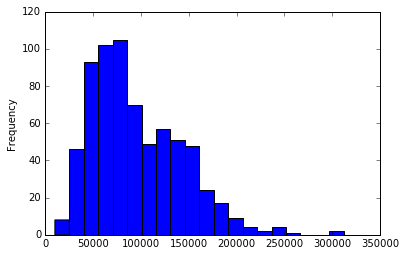

In [93]:
df_sal['salary_calc'].plot(kind='hist', bins=20)

In [94]:
[(c, df_sal[c].value_counts().count()) for c in list(df_sal.columns)]

[('company', 266),
 ('job_city', 21),
 ('job_link', 692),
 ('job_location', 167),
 ('job_posted', 43),
 ('job_title', 549),
 ('salary', 407),
 ('salary_calc', 304)]

In [3]:
## YOUR CODE HERE

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it
    - Remember to use `try/except` if you anticipate errors
- **Test** the functions on the results above and simple examples

In [4]:
## YOUR CODE HERE

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [359]:
from sklearn import linear_model, metrics, cross_validation, feature_extraction, grid_search
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

In [96]:
df_sal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 692 entries, 9 to 66331
Data columns (total 8 columns):
company         692 non-null object
job_city        692 non-null object
job_link        692 non-null object
job_location    692 non-null object
job_posted      692 non-null object
job_title       692 non-null object
salary          692 non-null object
salary_calc     692 non-null float64
dtypes: float64(1), object(7)
memory usage: 48.7+ KB


# Let's get the X and y

In [371]:
X = df_sal[df_sal['salary_calc'].isnull()==False]

In [372]:
X['salary_calc'].median()

85000.0

In [373]:
y = (X['salary_calc'] >= X['salary_calc'].median())

In [374]:
X = X.reindex(columns=['company','job_city','job_title'])

In [375]:
for col in ['company','job_city','job_title'] :
    X[col] = X[col].str.lower()

In [376]:
X['is_managerial'] = (X['job_title'].str.contains('senior')) | (X['job_title'].str.contains('manager'))

In [380]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)

## Now can go nuts on modelling

In [275]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X[self.columns])
        else:
            raise TypeError("This transformer only works with Pandas Dataframes")
    
    def fit(self, X, *_):
        return self
    

In [276]:
class GetDummiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.get_dummies(X[self.columns], columns = self.columns)
        else:
            raise TypeError("This transformer only works with Pandas Dataframes")
    
    def fit(self, X, *_):
        return self
    
#gdt = GetDummiesTransformer(['Embarked'])

In [277]:
class SelectOneColumn(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # return X.ix[:, self.column]
        return X[self.column]

In [278]:
class GetVectorizeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return feature_extraction.text.CountVectorizer().fit_transform(X[self.columns])
        else:
            raise TypeError("This transformer only works with Pandas Dataframes")
    
    def fit(self, X, *_):
        return self
    

In [385]:
cv = cross_validation.KFold(len(y_train), n_folds=5, shuffle=True)

### This is just brute force all dummies for the three features: company, job_city, job_title

In [386]:
company_pipe = make_pipeline(ColumnSelector('company'), GetDummiesTransformer(['company']))
job_city_pipe = make_pipeline(ColumnSelector('job_city'), GetDummiesTransformer(['job_city']))
job_title_pipe = make_pipeline(ColumnSelector('job_title'), GetDummiesTransformer(['job_title']))

In [387]:
union = make_union(company_pipe, job_city_pipe, job_title_pipe)


In [388]:
result = cross_validation.cross_val_score(linear_model.LogisticRegression(), X=union.fit_transform(X_train), y=y_train, cv=cv)

In [389]:
result

array([ 0.75257732,  0.74226804,  0.80412371,  0.71134021,  0.77083333])

In [390]:
result.mean()

0.75622852233676974

### well, better than 50%

## Let's try vectorizing job_title and only this feature

In [391]:
job_title_vec_pipe = make_pipeline(SelectOneColumn('job_title'), feature_extraction.text.CountVectorizer())

In [392]:
result = cross_validation.cross_val_score(linear_model.LogisticRegression(), X=job_title_vec_pipe.fit_transform(X_train), 
                                          y=y_train, cv=cv)

In [393]:
result

array([ 0.79381443,  0.82474227,  0.7628866 ,  0.80412371,  0.8125    ])

In [394]:
result.mean()

0.79961340206185572

### seems better

In [553]:
job_title_tfidf_pipe = make_pipeline(SelectOneColumn('job_title'), feature_extraction.text.TfidfVectorizer())

In [554]:
result = cross_validation.cross_val_score(linear_model.LogisticRegression(), X=job_title_tfidf_pipe.fit_transform(X_train), 
                                          y=y_train, cv=cv)

In [555]:
result

array([ 0.81443299,  0.82474227,  0.80412371,  0.81443299,  0.8125    ])

In [556]:
result.mean()

0.81404639175257731

## Let's try vectorized job_title and normal company, job_city

In [395]:
union2 = make_union(company_pipe, job_city_pipe, job_title_vec_pipe)


In [396]:
result = cross_validation.cross_val_score(linear_model.LogisticRegression(), 
                                          X=union2.fit_transform(X_train), y=y_train, cv=cv)

In [397]:
result

array([ 0.80412371,  0.84536082,  0.82474227,  0.81443299,  0.83333333])

In [398]:
result.mean()

0.82439862542955322

### Nice

## Vectorize everything?

In [399]:
company_vec_pipe = make_pipeline(SelectOneColumn('company'), feature_extraction.text.CountVectorizer())
job_city_vec_pipe = make_pipeline(SelectOneColumn('job_city'), feature_extraction.text.CountVectorizer())

In [400]:
union3 = make_union(company_vec_pipe, job_city_vec_pipe, job_title_vec_pipe)

In [401]:
result = cross_validation.cross_val_score(linear_model.LogisticRegression(), 
                                          X=union3.fit_transform(X_train), y=y_train, cv=cv)

In [402]:
result

array([ 0.82474227,  0.8556701 ,  0.84536082,  0.84536082,  0.80208333])

In [403]:
result.mean()

0.83464347079037804

### another improvement

## Grid search!!

In [411]:
grid_search_pipe = make_pipeline(union3, linear_model.LogisticRegression())

In [412]:
grid_search_pipe

Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(steps=[('selectonecolumn', SelectOneColumn(column='company')), ('countvectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'ut...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [413]:
param_grid = {
    'featureunion__pipeline-1__countvectorizer__ngram_range': [(1,1), (1,2), (2,2)],
   # 'featureunion__pipeline-1__countvectorizer__lowercase': [True, False],
    'featureunion__pipeline-1__countvectorizer__max_df': [0.7, 0.8, 0.9],
    'featureunion__pipeline-1__countvectorizer__max_features': [None, 10, 15],
    'logisticregression__C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'logisticregression__fit_intercept': [True, False],
    'logisticregression__penalty': ['l1', 'l2']    
}

In [414]:
gs = grid_search.GridSearchCV(grid_search_pipe, param_grid=param_grid, cv=cv, verbose=1, n_jobs=-1)

In [415]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Done  49 tasks       | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 199 tasks       | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 449 tasks       | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 799 tasks       | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 1249 tasks       | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 1799 tasks       | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2449 tasks       | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3199 tasks       | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  2.6min finished


GridSearchCV(cv=sklearn.cross_validation.KFold(n=484, n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(steps=[('selectonecolumn', SelectOneColumn(column='company')), ('countvectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'ut...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'logisticregression__penalty': ['l1', 'l2'], 'logisticregression__C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'featureunion__pipeline-1__countvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)], 'featureunion__pipeline-1__countvectorizer__max_features': [None, 10, 15], 'featureunion__pipeline-1__countvectorizer__max_df': [0.7, 0.8, 0.9], 'logisticregression__fit_intercept': [Tru

In [416]:
gs.best_estimator_

Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(steps=[('selectonecolumn', SelectOneColumn(column='company')), ('countvectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'ut...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [417]:
gs.best_params_

{'featureunion__pipeline-1__countvectorizer__max_df': 0.7,
 'featureunion__pipeline-1__countvectorizer__max_features': 15,
 'featureunion__pipeline-1__countvectorizer__ngram_range': (1, 1),
 'logisticregression__C': 1.0,
 'logisticregression__fit_intercept': True,
 'logisticregression__penalty': 'l2'}

In [418]:
gs.best_score_

0.84090909090909094

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [7]:
## YOUR CODE HERE

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now
1. Some of the entries may be duplicated
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries

In [9]:
## YOUR CODE HERE

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [10]:
## YOUR CODE HERE

### Save your results as a CSV

In [14]:
## YOUR CODE HERE

## Predicting salaries using Logistic Regression

#### Load in the the data of scraped salaries

In [12]:
## YOUR CODE HERE

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choice the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries, 

In [15]:
## YOUR CODE HERE

#### Thought experiment: What is the baseline accuracy for this model?

In [16]:
## YOUR CODE HERE

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [17]:
## YOUR CODE HERE

In [473]:
result = cross_validation.cross_val_score(linear_model.LogisticRegression(), 
                                          X=job_city_pipe.fit_transform(X_train), y=y_train, cv=cv)

In [474]:
result

array([ 0.67010309,  0.65979381,  0.57731959,  0.64948454,  0.6875    ])

In [475]:
result.mean()

0.64884020618556693

In [476]:
lm = linear_model.LogisticRegression()
lm.fit(job_city_pipe.fit_transform(X_train),y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [477]:
lm.coef_

array([[ 0.38391433,  0.01650927,  1.21669559,  0.07640578,  1.27624656,
        -0.0796461 , -0.43507449, -1.01412325,  0.14615706, -0.53726117,
         0.33910272,  0.86949688,  1.14522243, -0.39497192, -0.92184006,
        -1.27361291,  1.08194036,  1.24479266, -0.60365513, -1.24142493,
        -1.52445526]])

In [479]:
job_city_pipe.fit_transform(X_train).columns

Index([u'job_city_atlanta', u'job_city_austin', u'job_city_boston',
       u'job_city_cambridge', u'job_city_chicago', u'job_city_dallas',
       u'job_city_denver', u'job_city_houston', u'job_city_los+angeles',
       u'job_city_miami', u'job_city_new+york', u'job_city_palo+alto',
       u'job_city_philadelphia', u'job_city_phoenix', u'job_city_pittsburgh',
       u'job_city_portland', u'job_city_san+diego', u'job_city_san+francisco',
       u'job_city_seattle', u'job_city_st.+louis', u'job_city_washington'],
      dtype='object')

In [488]:
coeff_tuple = zip(job_city_pipe.fit_transform(X_train).columns, lm.coef_[0])

In [492]:
import operator

coeff_tuple.sort(key=operator.itemgetter(1), reverse=True)

In [493]:
coeff_tuple

[('job_city_chicago', 1.2762465588286407),
 ('job_city_san+francisco', 1.2447926637099176),
 ('job_city_boston', 1.2166955852551957),
 ('job_city_philadelphia', 1.1452224328462397),
 ('job_city_san+diego', 1.0819403601602604),
 ('job_city_palo+alto', 0.86949687662216391),
 ('job_city_atlanta', 0.38391433457854901),
 ('job_city_new+york', 0.33910271789441326),
 ('job_city_los+angeles', 0.14615706294583586),
 ('job_city_cambridge', 0.076405780969927575),
 ('job_city_austin', 0.016509267458983422),
 ('job_city_dallas', -0.079646095272128625),
 ('job_city_phoenix', -0.39497191968407253),
 ('job_city_denver', -0.43507449433271062),
 ('job_city_miami', -0.53726117220347691),
 ('job_city_seattle', -0.6036551264854878),
 ('job_city_pittsburgh', -0.92184005888751841),
 ('job_city_houston', -1.0141232491515897),
 ('job_city_st.+louis', -1.2414249252418996),
 ('job_city_portland', -1.2736129059385481),
 ('job_city_washington', -1.5244552612434616)]

In [494]:
#for i,j in zip(job_city_pipe.fit_transform(X_train).columns, lm.coef_[0]):
#    print i.replace('job_city_',''), j

### This tells which city is positively or negatively correlated with higher or lower salaries. So, a big positive number means more higher paying jobs. Chicago, San Francisco, and Boston have all the high paying jobs.

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [18]:
## YOUR CODE HERE

In [542]:
is_managerial_pipe = make_pipeline(ColumnSelector('is_managerial'))

In [543]:
X_train.head()

,company,job_city,job_title,is_managerial
56576,washington state patrol,washington,office assistant 3 - criminal records di...,False
66272,s & s professional services,st.+louis,global environmental data scientist,False
27209,the university of pittsburgh,pittsburgh,laboratory technician,False
24750,centers for disease control and prevention,atlanta,health scientist,False
33708,"maricopa county, az",phoenix,public health scientist,False


In [544]:
union4 = make_union(company_vec_pipe, job_city_vec_pipe, job_title_vec_pipe, is_managerial_pipe)

In [545]:
grid_search_senior_pipe = make_pipeline(union4, linear_model.LogisticRegression())

In [546]:
param_grid_senior = {
    'featureunion__pipeline-1__countvectorizer__ngram_range': [(1,1), (1,2), (2,2)],
   # 'featureunion__pipeline-1__countvectorizer__lowercase': [True, False],
    'featureunion__pipeline-1__countvectorizer__max_df': [0.7, 0.8, 0.9],
    'featureunion__pipeline-1__countvectorizer__max_features': [None, 10, 15],
    'logisticregression__C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'logisticregression__fit_intercept': [True, False],
    'logisticregression__penalty': ['l1', 'l2']    
}

In [547]:
gs_senior = grid_search.GridSearchCV(grid_search_senior_pipe, param_grid=param_grid_senior, cv=cv, verbose=1, n_jobs=-1)

In [548]:
gs_senior.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Done  49 tasks       | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 199 tasks       | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 449 tasks       | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 799 tasks       | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 1249 tasks       | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1799 tasks       | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2449 tasks       | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3199 tasks       | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  2.9min finished


GridSearchCV(cv=sklearn.cross_validation.KFold(n=484, n_folds=5, shuffle=True, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(steps=[('selectonecolumn', SelectOneColumn(column='company')), ('countvectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'ut...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'logisticregression__penalty': ['l1', 'l2'], 'logisticregression__C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'featureunion__pipeline-1__countvectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)], 'featureunion__pipeline-1__countvectorizer__max_features': [None, 10, 15], 'featureunion__pipeline-1__countvectorizer__max_df': [0.7, 0.8, 0.9], 'logisticregression__fit_intercept': [Tru

In [549]:
gs_senior.best_estimator_

Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(steps=[('selectonecolumn', SelectOneColumn(column='company')), ('countvectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'ut...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [550]:
gs_senior.best_params_

{'featureunion__pipeline-1__countvectorizer__max_df': 0.7,
 'featureunion__pipeline-1__countvectorizer__max_features': None,
 'featureunion__pipeline-1__countvectorizer__ngram_range': (1, 1),
 'logisticregression__C': 1.0,
 'logisticregression__fit_intercept': True,
 'logisticregression__penalty': 'l2'}

In [551]:
gs_senior.best_score_

0.83884297520661155

### Slightly better vs the 0.834 for the all vectorized 3 features non grid search

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [19]:
## YOUR CODE HERE

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [20]:
## YOUR CODE HERE

In [439]:
est = gs.best_estimator_

In [440]:
est.fit(X_train, y_train)

Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('pipeline-1', Pipeline(steps=[('selectonecolumn', SelectOneColumn(column='company')), ('countvectorizer', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'ut...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [441]:
est.score(X_test, y_test)

0.82211538461538458

In [442]:
gs.score(X_test, y_test)

0.82211538461538458

In [419]:
y_pred = gs.predict(X_test)

In [420]:
conmat = np.array(confusion_matrix(y_test, y_pred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['high_salary', 'low_salary'],
                         columns=['predicted_high_salary','predicted_low_salary'])

print(confusion)

             predicted_high_salary  predicted_low_salary
high_salary                     92                    23
low_salary                      14                    79


In [421]:
acc = accuracy_score(y_test, y_pred)
print(acc)

0.822115384615


In [422]:
cls_rep = classification_report(y_test, y_pred)
print(cls_rep)

             precision    recall  f1-score   support

      False       0.77      0.85      0.81        93
       True       0.87      0.80      0.83       115

avg / total       0.83      0.82      0.82       208



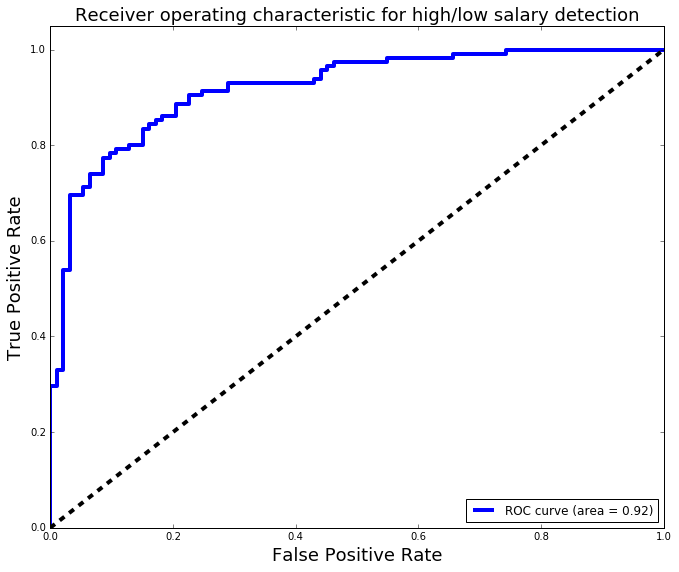

In [423]:
y_score = gs.decision_function(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for high/low salary detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### This is a high precision and low recall model

#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [21]:
## YOUR CODE HERE

In [22]:
## YOUR CODE HERE

#### Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients

#### Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary - which entries have the highest predicted salaries?

In [433]:
df_test_set = X_test.copy()
df_test_set['is_high_salary'] = y_pred

In [446]:
df_test_set = pd.merge(df_test_set, df_sal[['salary_calc']], how='left', left_index=True, right_index=True)

In [449]:
df_test_set.sort_values('salary_calc',ascending=False).head(20)

,company,job_city,job_title,is_managerial,is_high_salary,salary_calc
157,harnham,new+york,chief data scientist - consulting,False,True,220000.0
24828,selby jennings,atlanta,statistical credit risk modeler | top performing investment bank,False,True,212500.0
237,datacom technology group,new+york,data scientist,False,True,200000.0
518,averity,new+york,senior/ lead data scientist for digital media company,True,True,200000.0
17086,harnham,los+angeles,"vp of analytics - los angeles - r, models, media entertainment",False,True,200000.0
43450,njf search,boston,software engineer - machine learning team,False,True,200000.0
425,green key resources,new+york,data analysis specialist,False,False,195000.0
14764,all-in analytics,seattle,senior business intelligence data scientist,True,True,190000.0
14886,all-in analytics,seattle,senior business intelligence scientist,True,True,190000.0
61766,jobspring partners,palo+alto,sr. software engineer-machine learning,False,True,187500.0


In [487]:
X_test.head()

,company,job_city,job_title,is_managerial,is_high_salary
15129,university of washington medical center,seattle,driver-warehouse worker,False,False
940,selby jennings,new+york,vp statistical analyst | top investment bank,False,True
312,hra/dept of social services,new+york,data research coordinator,False,False
5238,smith hanley associates,chicago,statistical analyst,False,True
17089,north orange county community college district,los+angeles,research analyst,False,False


In [528]:
job_test = pd.DataFrame([["watever company","slump","fake job"]], columns=['company','job_city','job_title'])
gs.predict(job_test)

array([False], dtype=bool)

In [529]:
job_test = pd.DataFrame([["watever company","chicago","fake job"]], columns=['company','job_city','job_title'])
gs.predict(job_test)

array([False], dtype=bool)

In [552]:
job_test = pd.DataFrame([["watever company","slump","senior fake job"]], columns=['company','job_city','job_title'])
gs.predict(job_test)

array([ True], dtype=bool)

In [532]:
job_test = pd.DataFrame([["workbridge associates","chicago","fake job"]], columns=['company','job_city','job_title'])
gs.predict(job_test)

array([ True], dtype=bool)

### Whoa, it seems workbridge asscoiates has all the great jobs, even it is a fake one and work in a slump!

In [533]:
job_test = pd.DataFrame([["workbridge associates","slump","fake job"]], columns=['company','job_city','job_title'])
gs.predict(job_test)

array([ True], dtype=bool)

In [537]:
job_test = pd.DataFrame([["selby jennings","slump","fake job"]], columns=['company','job_city','job_title'])
gs.predict(job_test)

array([False], dtype=bool)

In [541]:
job_test = pd.DataFrame([["watever associates","slump","fake job"]], columns=['company','job_city','job_title'])
gs.predict(job_test)

array([ True], dtype=bool)

### Oops, it is this magical 'associates' which is special for the hiring company...

In [534]:
job_test = pd.DataFrame([["watever company","slump","manager"]], columns=['company','job_city','job_title'])
gs.predict(job_test)

array([ True], dtype=bool)

In [525]:
X_train.company.value_counts().head()

workbridge associates            25
jobspring partners               23
state of washington              22
university of texas at austin    19
washington state government      18
Name: company, dtype: int64

### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [23]:
## YOUR CODE HERE

In [24]:
## YOUR CODE HERE

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [25]:
## YOUR CODE HERE